#SemEval-2017 Task 4 – Subtask B (English Twitter, topic-based 2-class sentiment)
## Deep Learning Project – BERTweet & RoBERTa Fine-tuning

This notebook implements the compl\ete pipeline for **Subtask B**:
- Input: (topic, tweet)
- Output: POSITIVE / NEGATIVE

It follows the same structure & hyperparameters as your Subtask A notebook:
- Uses the official SemEval-2017 Task 4 English data from `2017_English_final.zip`
- Loads all GOLD/Subtasks_BD Twitter files
- Filters to **positive/negative** only (drops neutral / other labels)
- Randomly splits into **train / dev / test** via stratified split
- Applies light tweet preprocessing (`<URL>`, `<USER>` placeholders)
- Fine-tunes two transformer models in **cross-encoder** mode:
  - `vinai/bertweet-base`
  - `roberta-base`
- Uses:
  - Learning rate **2e-5**
  - Weight decay **0.01**
  - **5% warmup** for the learning rate schedule
  - Increased dropout (**0.2**) in the encoder
  - **Early stopping** based on dev AvgRec (patience = 2)
- Evaluates on the held-out test split (global metrics + confusion matrix)
- Saves:
  - Best checkpoints: `bertweet_subtaskB_best/`, `roberta_subtaskB_best/`
  - All models: `saved_models_subtaskB/`
  - Metrics CSVs: `history_subtaskB_all.csv`, `test_results_subtaskB.csv`
"""

In [ ]:
# ============================================================
# 0. Install dependencies (run once per Colab session)
# ============================================================
!pip install -q transformers emoji scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 11.0 MB/s eta 0:00:00


# 1. Imports, device setup, and global configuration

In [ ]:
# ============================================================
# 1. Imports, device, config
# ============================================================
import os, re, zipfile, random, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    get_linear_schedule_with_warmup,
)

from tqdm.auto import tqdm
from google.colab import files
from IPython.display import display

# ---------------- Device ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------- Seed ----------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# ---------------- Labels (Subtask B = 2-class) ----------------
label2id = {
    "negative": 0,
    "positive": 1,
}
id2label = {v: k for k, v in label2id.items()}
num_labels = len(label2id)

# ---------------- Hyperparameters ----------------
BATCH_SIZE    = 16     # same as Subtask A
MAX_LEN       = 128
EPOCHS        = 4
LR            = 2e-5
WEIGHT_DECAY  = 0.01
WARMUP_RATIO  = 0.05   # 5% warmup
MAX_GRAD_NORM = 1.0
PATIENCE      = 2      # early stopping on AvgRec

print(f"Hyperparams -> LR={LR}, BATCH_SIZE={BATCH_SIZE}, MAX_LEN={MAX_LEN}, "
      f"EPOCHS={EPOCHS}, WARMUP_RATIO={WARMUP_RATIO}, PATIENCE={PATIENCE}")

Using device: cuda
Hyperparams -> LR=2e-05, BATCH_SIZE=16, MAX_LEN=128, EPOCHS=4, WARMUP_RATIO=0.05, PATIENCE=2


# 2. Upload SemEval 2017 English data zip"""

In [ ]:
# ============================================================
# 2. Upload SemEval 2017 English data zip
# ============================================================
print("Please upload 2017_English_final.zip from your computer.")
uploaded = files.upload()

zip_path = next(iter(uploaded.keys()))
print("Using zip file:", zip_path)

Please upload 2017_English_final.zip from your computer.


Saving 2017_English_final (1).zip to 2017_English_final (1).zip
Using zip file: 2017_English_final (1).zip


# 3. Read Subtasks_BD Twitter files and build splits"""

In [ ]:
# ============================================================
# 3. Read GOLD/Subtasks_BD Twitter files
# ============================================================
GOLD_SUBTASK_BD_DIR = "2017_English_final/GOLD/Subtasks_BD"

def list_subtask_b_files(zip_path: str):
    bd_files = []
    with zipfile.ZipFile(zip_path, "r") as z:
        for name in z.namelist():
            if name.startswith(GOLD_SUBTASK_BD_DIR) and name.endswith(".txt") and "twitter" in name:
                bd_files.append(name)
    return sorted(bd_files)

bd_files = list_subtask_b_files(zip_path)
print(f"Found {len(bd_files)} Subtasks_BD Twitter files:")
for f in bd_files:
    print("  -", f)

def read_subtask_b_all(zip_path: str, file_list):
    """
    Read all Subtasks_BD Twitter files into a DataFrame.
    Each line is assumed to be:
        tweet_id \\t topic \\t label \\t tweet_text
    but we join any extra columns into the tweet_text to be safe.
    """
    rows = []
    with zipfile.ZipFile(zip_path, "r") as z:
        for fname in file_list:
            with z.open(fname) as f:
                for line in f:
                    line = line.decode("utf-8", errors="ignore").strip()
                    if not line or line == '"':
                        continue
                    parts = line.split("\t")
                    # we expect at least 4 columns
                    if len(parts) < 4:
                        continue
                    tweet_id = parts[0]
                    topic    = parts[1]
                    label    = parts[2].lower()
                    text     = " ".join(parts[3:])
                    rows.append(
                        {
                            "tweet_id": tweet_id,
                            "topic": topic,
                            "label": label,
                            "text": text,
                            "source_file": os.path.basename(fname),
                        }
                    )
    return pd.DataFrame(rows)

df_all_raw = read_subtask_b_all(zip_path, bd_files)
print("Raw total rows (all labels):", len(df_all_raw))
print(df_all_raw.head())

# ============================================================
# 3.1 Filter to positive/negative only, deduplicate
# ============================================================
valid_labels = {"positive", "negative"}
df_all = df_all_raw[df_all_raw["label"].isin(valid_labels)].copy()

print("\nAfter filtering to POS/NEG only:")
print("  Rows:", len(df_all))
print(df_all["label"].value_counts())

# Deduplicate by (topic, tweet_id) so same tweet for different topics is kept
df_all = df_all.drop_duplicates(subset=["topic", "tweet_id"]).reset_index(drop=True)
print("\nAfter dropping duplicates by (topic, tweet_id):", len(df_all))

# ============================================================
# 3.2 Train/dev/test split (stratified on label)
# ============================================================
df_train, df_temp = train_test_split(
    df_all,
    test_size=0.3,
    stratify=df_all["label"],
    random_state=42,
)

df_dev, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp["label"],
    random_state=42,
)

df_train = df_train.reset_index(drop=True)
df_dev   = df_dev.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

print("\nSplit sizes:")
print("  Train:", len(df_train))
print("  Dev  :", len(df_dev))
print("  Test :", len(df_test))

def show_label_stats(df, name):
    print(f"\n=== {name} label distribution ===")
    print(df["label"].value_counts())
    display(df["label"].value_counts(normalize=True).rename("proportion").to_frame())

show_label_stats(df_train, "Train")
show_label_stats(df_dev,   "Dev")
show_label_stats(df_test,  "Test")


Found 6 Subtasks_BD Twitter files:
  - 2017_English_final/GOLD/Subtasks_BD/twitter-2015testBD.txt
  - 2017_English_final/GOLD/Subtasks_BD/twitter-2015train-BD.txt
  - 2017_English_final/GOLD/Subtasks_BD/twitter-2016dev-BD.txt
  - 2017_English_final/GOLD/Subtasks_BD/twitter-2016devtest-BD.txt
  - 2017_English_final/GOLD/Subtasks_BD/twitter-2016test-BD.txt
  - 2017_English_final/GOLD/Subtasks_BD/twitter-2016train-BD.txt
Raw total rows (all labels): 20511
             tweet_id          topic     label  \
0  522712800595300352  aaron rodgers   neutral   
1  522559216645840897  aaron rodgers   neutral   
2  522560839211962368  aaron rodgers   neutral   
3  523065089977757696  aaron rodgers  negative   
4  522563839305338880  aaron rodgers   neutral   

                                                text             source_file  
0  I just cut a 25 second audio clip of Aaron Rod...  twitter-2015testBD.txt  
1  Tough loss for the Dolphins last Sunday in Mia...  twitter-2015testBD.txt  
2  I'

,proportion
label,
positive,0.788383
negative,0.211617



=== Dev label distribution ===
label
positive    2243
negative     602
Name: count, dtype: int64


,proportion
label,
positive,0.788401
negative,0.211599



=== Test label distribution ===
label
positive    2243
negative     602
Name: count, dtype: int64


,proportion
label,
positive,0.788401
negative,0.211599


# 4. Tweet preprocessing and Dataset class (cross-encoder: topic + tweet)

In [ ]:
# ============================================================
# 4. Tweet preprocessing & Dataset class
# ============================================================
URL_RE = re.compile(r"http\S+|www\.\S+")
USER_RE = re.compile(r"@\w+")

def preprocess_tweet(text: str) -> str:
    # Same light normalization as Subtask A
    text = URL_RE.sub(" <URL> ", text)
    text = USER_RE.sub(" <USER> ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

print(preprocess_tweet("RT @user: Check https://t.co/abc for more info #topic :D"))

class TopicTweetSentimentDataset(Dataset):
    """
    Dataset for Subtask B: each example is (topic, tweet -> label).
    We feed (topic, tweet) into the tokenizer to build a cross-encoder input:
        [CLS] topic [SEP] tweet [SEP]
    """
    def __init__(self, df, tokenizer, max_len, label2id):
        df = df.reset_index(drop=True)
        self.topics = df["topic"].tolist()
        self.texts  = df["text"].tolist()
        self.labels = [label2id[l] for l in df["label"]]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        topic = str(self.topics[idx])
        tweet_raw = self.texts[idx]
        tweet = preprocess_tweet(tweet_raw)

        encoded = self.tokenizer(
            topic,
            tweet,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        item = {k: v.squeeze(0) for k, v in encoded.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

RT <USER> : Check <URL> for more info #topic :D


# 5. Metrics and visualization helpers (2-class)

In [ ]:
# ============================================================
# 5. Metrics and visualization helpers (2-class)
# ============================================================
def compute_metrics_binary(y_true, y_pred, label_names=("negative", "positive")):
    report = classification_report(
        y_true,
        y_pred,
        target_names=list(label_names),
        output_dict=True,
        zero_division=0,
    )
    acc = accuracy_score(y_true, y_pred)

    recalls = [report[label]["recall"] for label in label_names]
    avgrec = float(sum(recalls) / len(recalls))

    f1_macro = (report["negative"]["f1-score"] + report["positive"]["f1-score"]) / 2.0

    metrics = {
        "accuracy": acc,
        "avgrec": avgrec,
        "f1_macro": f1_macro,
        "report": report,
    }
    return metrics

def plot_confusion_matrix(cm, labels, title):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels,
        yticklabels=labels,
        ylabel="True label",
        xlabel="Predicted label",
        title=title,
    )

    fmt = "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    fig.tight_layout()
    plt.show()

def plot_history(history_df, model_name):
    df = history_df[history_df["model_name"] == model_name]

    # Loss vs epoch
    plt.figure()
    plt.plot(df["epoch"], df["train_loss"], marker="o", label="train_loss")
    plt.plot(df["epoch"], df["dev_loss"], marker="o", label="dev_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss vs Epoch ({model_name})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Dev metrics vs epoch
    plt.figure()
    plt.plot(df["epoch"], df["dev_accuracy"], marker="o", label="dev_accuracy")
    plt.plot(df["epoch"], df["dev_avgrec"], marker="o", label="dev_avgrec")
    plt.plot(df["epoch"], df["dev_f1_macro"], marker="o", label="dev_f1_macro")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title(f"Dev metrics vs Epoch ({model_name})")
    plt.legend()
    plt.grid(True)
    plt.show()

# 6. Dataloaders, training loop, evaluation

In [ ]:
# ============================================================
# 6. Dataloaders, training loop, evaluation
# ============================================================
def create_data_loader(df, tokenizer, max_len, batch_size, label2id, shuffle=False):
    dataset = TopicTweetSentimentDataset(df, tokenizer, max_len, label2id)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def train_one_epoch(model, data_loader, optimizer, scheduler, device, max_grad_norm=1.0):
    model.train()
    total_loss = 0.0
    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
        )
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(data_loader)
    return avg_loss

def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            labels = batch["labels"].to(device)
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
            }

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)
            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())

            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(data_loader)
    return avg_loss, np.array(all_labels), np.array(all_preds)

#7. DEBUG MODE: gunakan subset kecil + 1 epoch kalau mau tes cepat

In [ ]:
# ============================================================
# 7. DEBUG MODE: gunakan subset kecil + 1 epoch kalau mau tes cepat
# ============================================================
DEBUG = False  # set True untuk debug cepat (500 contoh, 1 epoch)

if DEBUG:
    df_train_debug = df_train.sample(n=min(500, len(df_train)), random_state=42)
    df_dev_debug   = df_dev.sample(n=min(500, len(df_dev)), random_state=42)
    EPOCHS_DEBUG = 1
else:
    df_train_debug = df_train
    df_dev_debug   = df_dev
    EPOCHS_DEBUG = EPOCHS

# 8. Training function for a single model (Subtask B)

In [ ]:
# ============================================================
# 8. Training function for a single model (Subtask B)
# ============================================================
def run_experiment(model_name: str, df_train, df_dev,
                   max_len=MAX_LEN, batch_size=BATCH_SIZE,
                   lr=LR, weight_decay=WEIGHT_DECAY,
                   epochs=EPOCHS, warmup_ratio=WARMUP_RATIO,
                   max_grad_norm=MAX_GRAD_NORM, patience=PATIENCE):
    print(f"\n===== Training {model_name} on Subtask B =====")

    # BERTweet uses a non-fast tokenizer
    use_fast = False if "bertweet" in model_name.lower() else True

    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        use_fast=use_fast,
    )

    # Config: 2 labels + stronger dropout
    config = AutoConfig.from_pretrained(model_name)
    config.num_labels = num_labels
    config.id2label = id2label
    config.label2id = label2id

    if hasattr(config, "hidden_dropout_prob"):
        config.hidden_dropout_prob = 0.2
    if hasattr(config, "attention_probs_dropout_prob"):
        config.attention_probs_dropout_prob = 0.2

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config,
    )
    model.to(device)

    train_loader = create_data_loader(df_train, tokenizer, max_len, batch_size, label2id, shuffle=True)
    dev_loader   = create_data_loader(df_dev,   tokenizer, max_len, batch_size, label2id, shuffle=False)

    total_steps  = len(train_loader) * epochs
    warmup_steps = int(warmup_ratio * total_steps)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    history = []
    best_dev_avgrec = -1.0
    best_state_dict = None
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        train_loss = train_one_epoch(
            model, train_loader, optimizer, scheduler, device, max_grad_norm
        )
        print(f"  Train loss: {train_loss:.4f}")

        dev_loss, dev_y_true, dev_y_pred = eval_model(model, dev_loader, device)
        dev_metrics = compute_metrics_binary(dev_y_true, dev_y_pred)

        print(f"  Dev loss   : {dev_loss:.4f}")
        print(f"  Dev Acc    : {dev_metrics['accuracy']:.4f}")
        print(f"  Dev AvgRec : {dev_metrics['avgrec']:.4f}")
        print(f"  Dev F1_mac : {dev_metrics['f1_macro']:.4f}")

        history.append({
            "model_name": model_name,
            "epoch": epoch,
            "train_loss": train_loss,
            "dev_loss": dev_loss,
            "dev_accuracy": dev_metrics["accuracy"],
            "dev_avgrec": dev_metrics["avgrec"],
            "dev_f1_macro": dev_metrics["f1_macro"],
            "lr": lr,
            "max_len": max_len,
            "batch_size": batch_size,
        })

        # Early stopping on AvgRec
        if dev_metrics["avgrec"] > best_dev_avgrec:
            best_dev_avgrec = dev_metrics["avgrec"]
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
            print(f"  --> New best dev AvgRec: {best_dev_avgrec:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  No improvement in AvgRec for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    history_df = pd.DataFrame(history)

    # Restore best weights
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)

    return model, tokenizer, history_df

# 9. Run experiments for BERTweet and RoBERTa (Subtask B)

In [ ]:
# ============================================================
# 9. Run experiments for BERTweet and RoBERTa (Subtask B)
# ============================================================
set_seed(42)

MODEL_NAMES = [
    "vinai/bertweet-base",
    "roberta-base",
]

all_histories = []
models = {}
tokenizers = {}

for mname in MODEL_NAMES:
    model, tokenizer, hist_df = run_experiment(
        model_name=mname,
        df_train=df_train_debug,
        df_dev=df_dev_debug,
        max_len=MAX_LEN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS_DEBUG,
        warmup_ratio=WARMUP_RATIO,
        max_grad_norm=MAX_GRAD_NORM,
        patience=PATIENCE,
    )
    models[mname] = model
    tokenizers[mname] = tokenizer
    all_histories.append(hist_df)

history_all = pd.concat(all_histories, ignore_index=True)
print("\n=== Training history (all models) ===")
display(history_all)



===== Training vinai/bertweet-base on Subtask B =====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4


Training:   0%|          | 0/830 [00:00<?, ?it/s]

  Train loss: 0.3206


Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

  Dev loss   : 0.2245
  Dev Acc    : 0.9192
  Dev AvgRec : 0.8454
  Dev F1_mac : 0.8699
  --> New best dev AvgRec: 0.8454

Epoch 2/4


Training:   0%|          | 0/830 [00:00<?, ?it/s]

  Train loss: 0.2082


Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

  Dev loss   : 0.2135
  Dev Acc    : 0.9279
  Dev AvgRec : 0.8759
  Dev F1_mac : 0.8884
  --> New best dev AvgRec: 0.8759

Epoch 3/4


Training:   0%|          | 0/830 [00:00<?, ?it/s]

  Train loss: 0.1456


Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

  Dev loss   : 0.2220
  Dev Acc    : 0.9381
  Dev AvgRec : 0.9115
  Dev F1_mac : 0.9081
  --> New best dev AvgRec: 0.9115

Epoch 4/4


Training:   0%|          | 0/830 [00:00<?, ?it/s]

  Train loss: 0.1108


Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

  Dev loss   : 0.2636
  Dev Acc    : 0.9353
  Dev AvgRec : 0.9067
  Dev F1_mac : 0.9038
  No improvement in AvgRec for 1 epoch(s).

===== Training roberta-base on Subtask B =====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4


Training:   0%|          | 0/830 [00:00<?, ?it/s]

  Train loss: 0.3454


Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

  Dev loss   : 0.2387
  Dev Acc    : 0.9139
  Dev AvgRec : 0.8427
  Dev F1_mac : 0.8630
  --> New best dev AvgRec: 0.8427

Epoch 2/4


Training:   0%|          | 0/830 [00:00<?, ?it/s]

  Train loss: 0.2307


Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

  Dev loss   : 0.2366
  Dev Acc    : 0.9170
  Dev AvgRec : 0.8878
  Dev F1_mac : 0.8786
  --> New best dev AvgRec: 0.8878

Epoch 3/4


Training:   0%|          | 0/830 [00:00<?, ?it/s]

  Train loss: 0.1800


Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

  Dev loss   : 0.2636
  Dev Acc    : 0.9220
  Dev AvgRec : 0.8964
  Dev F1_mac : 0.8861
  --> New best dev AvgRec: 0.8964

Epoch 4/4


Training:   0%|          | 0/830 [00:00<?, ?it/s]

  Train loss: 0.1555


Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

  Dev loss   : 0.3128
  Dev Acc    : 0.9258
  Dev AvgRec : 0.8776
  Dev F1_mac : 0.8863
  No improvement in AvgRec for 1 epoch(s).

=== Training history (all models) ===


,model_name,epoch,train_loss,dev_loss,dev_accuracy,dev_avgrec,dev_f1_macro,lr,max_len,batch_size
0,vinai/bertweet-base,1,0.320601,0.224536,0.919156,0.845429,0.869859,0.00002,128,16
1,vinai/bertweet-base,2,0.208154,0.213471,0.927944,0.875916,0.888365,0.00002,128,16
2,vinai/bertweet-base,3,0.145589,0.221952,0.938137,0.911547,0.908072,0.00002,128,16
3,vinai/bertweet-base,4,0.110845,0.263648,0.935325,0.906726,0.903779,0.00002,128,16
4,roberta-base,1,0.345441,0.238724,0.913884,0.842693,0.862986,0.00002,128,16
5,roberta-base,2,0.230729,0.236625,0.917047,0.887842,0.878604,0.00002,128,16
6,roberta-base,3,0.180028,0.263649,0.921968,0.896432,0.886069,0.00002,128,16
7,roberta-base,4,0.155473,0.312786,0.925835,0.877616,0.886272,0.00002,128,16


# 10. Plot training & validation curves

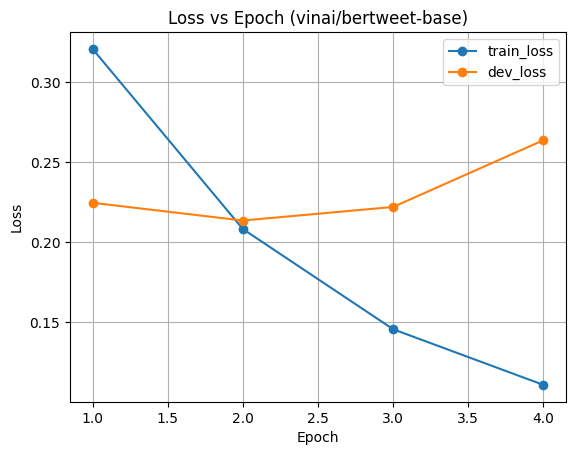

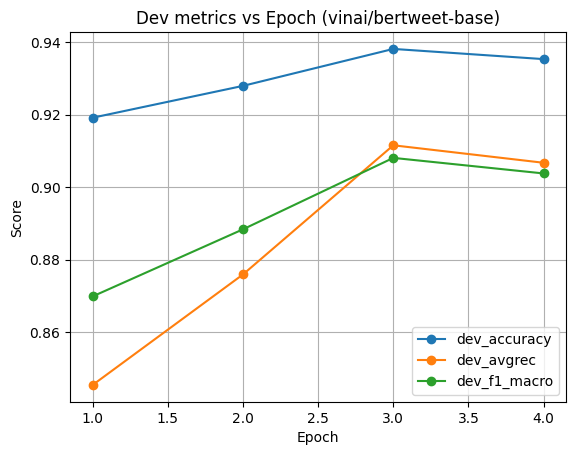

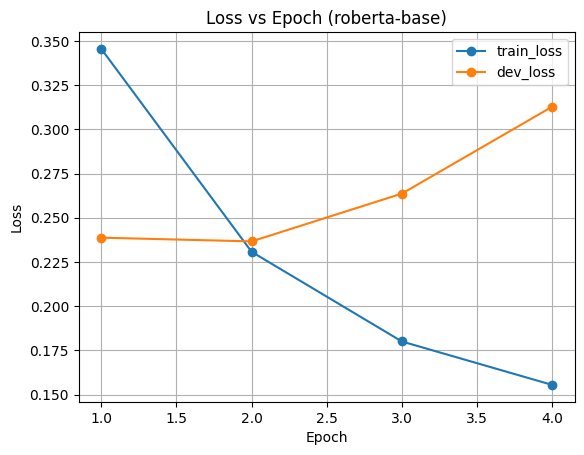

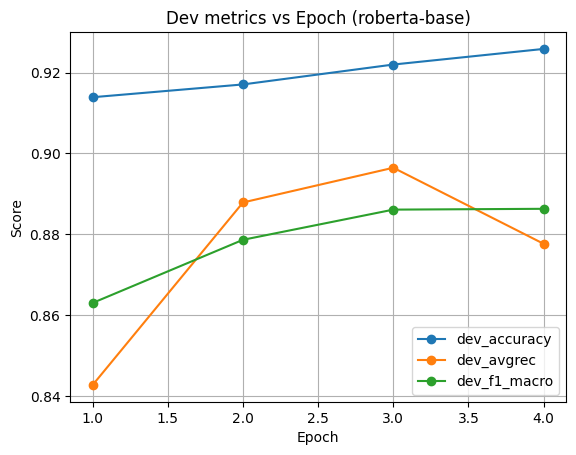

In [ ]:
# ============================================================
# 10. Plot training & validation curves
# ============================================================
for mname in MODEL_NAMES:
    plot_history(history_all, mname)


# 10.5 (Optional) Fine-tune from best checkpoint with smaller LR

In [ ]:
# ============================================================
# 10.5 (Optional) Fine-tune from best checkpoint with smaller LR
# Run this AFTER the first training loop (history_all is defined)
# and BEFORE the final test evaluation.
# ============================================================

FINE_TUNE = True          # set to False if you don't want this stage
LR_FINE = 1e-5            # smaller learning rate for fine-tuning
EPOCHS_FINE = 2           # a few extra epochs only
WARMUP_RATIO_FINE = 0.05  # can keep same warmup ratio

if FINE_TUNE:
    print("\n===== Stage 2: Fine-tuning from best checkpoints (Subtask B) =====")
    fine_histories = []

    for mname in MODEL_NAMES:
        print(f"\n=== Fine-tuning {mname} from best dev checkpoint ===")
        model = models[mname]        # this is already loaded with best_state_dict
        tokenizer = tokenizers[mname]

        train_loader = create_data_loader(
            df_train_debug, tokenizer, MAX_LEN, BATCH_SIZE, label2id, shuffle=True
        )
        dev_loader = create_data_loader(
            df_dev_debug, tokenizer, MAX_LEN, BATCH_SIZE, label2id, shuffle=False
        )

        total_steps  = len(train_loader) * EPOCHS_FINE
        warmup_steps = int(WARMUP_RATIO_FINE * total_steps)

        optimizer = AdamW(model.parameters(), lr=LR_FINE, weight_decay=WEIGHT_DECAY)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps,
        )

        best_dev_avgrec_fine = -1.0
        best_state_fine = None

        # just to keep epoch numbers continuous in history_all
        prev_max_epoch = history_all[history_all["model_name"] == mname]["epoch"].max()

        for e in range(1, EPOCHS_FINE + 1):
            print(f"\n[Fine-tune] Epoch {e}/{EPOCHS_FINE} for {mname}")
            train_loss = train_one_epoch(
                model, train_loader, optimizer, scheduler,
                device, max_grad_norm=MAX_GRAD_NORM
            )
            dev_loss, dev_y_true, dev_y_pred = eval_model(model, dev_loader, device)
            dev_metrics = compute_metrics_binary(dev_y_true, dev_y_pred)

            print(f"  Train loss: {train_loss:.4f}")
            print(f"  Dev loss  : {dev_loss:.4f}")
            print(f"  Dev Acc   : {dev_metrics['accuracy']:.4f}")
            print(f"  Dev AvgRec: {dev_metrics['avgrec']:.4f}")
            print(f"  Dev F1_mac: {dev_metrics['f1_macro']:.4f}")

            # log to history (epoch number continues from stage 1)
            fine_histories.append({
                "model_name": mname,
                "epoch": prev_max_epoch + e,
                "train_loss": train_loss,
                "dev_loss": dev_loss,
                "dev_accuracy": dev_metrics["accuracy"],
                "dev_avgrec": dev_metrics["avgrec"],
                "dev_f1_macro": dev_metrics["f1_macro"],
                "lr": LR_FINE,
                "max_len": MAX_LEN,
                "batch_size": BATCH_SIZE,
            })

            # keep best AvgRec within fine-tuning stage
            if dev_metrics["avgrec"] > best_dev_avgrec_fine:
                best_dev_avgrec_fine = dev_metrics["avgrec"]
                best_state_fine = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                print(f"  --> New best fine-tune AvgRec: {best_dev_avgrec_fine:.4f}")

        # restore best fine-tune weights (if any improvement)
        if best_state_fine is not None:
            model.load_state_dict(best_state_fine)
            model.to(device)

        # update the global dict with the fine-tuned model
        models[mname] = model

    # merge fine-tune history into main history_all
    if fine_histories:
        history_all = pd.concat(
            [history_all, pd.DataFrame(fine_histories)],
            ignore_index=True
        )

    print("\nFine-tuning stage done. Now re-run the TEST evaluation cell below.")
else:
    print("Skipping fine-tuning stage (FINE_TUNE=False).")



===== Stage 2: Fine-tuning from best checkpoints (Subtask B) =====

=== Fine-tuning vinai/bertweet-base from best dev checkpoint ===

[Fine-tune] Epoch 1/2 for vinai/bertweet-base


Training:   0%|          | 0/830 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

  Train loss: 0.1216
  Dev loss  : 0.2529
  Dev Acc   : 0.9343
  Dev AvgRec: 0.9085
  Dev F1_mac: 0.9028
  --> New best fine-tune AvgRec: 0.9085

[Fine-tune] Epoch 2/2 for vinai/bertweet-base


Training:   0%|          | 0/830 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

  Train loss: 0.0896
  Dev loss  : 0.2818
  Dev Acc   : 0.9378
  Dev AvgRec: 0.9065
  Dev F1_mac: 0.9067

=== Fine-tuning roberta-base from best dev checkpoint ===

[Fine-tune] Epoch 1/2 for roberta-base


Training:   0%|          | 0/830 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

  Train loss: 0.1612
  Dev loss  : 0.3275
  Dev Acc   : 0.9244
  Dev AvgRec: 0.8810
  Dev F1_mac: 0.8854
  --> New best fine-tune AvgRec: 0.8810

[Fine-tune] Epoch 2/2 for roberta-base


Training:   0%|          | 0/830 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

  Train loss: 0.1429
  Dev loss  : 0.3661
  Dev Acc   : 0.9262
  Dev AvgRec: 0.8760
  Dev F1_mac: 0.8863

Fine-tuning stage done. Now re-run the TEST evaluation cell below.



# 11. Final evaluation on TEST set (Subtask B)


===== Final evaluation on TEST for vinai/bertweet-base =====


Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

Test loss  : 0.2828
Test Acc   : 0.9272
Test AvgRec: 0.9052
Test F1_mac: 0.8940

Classification report:


,precision,recall,f1-score,support
negative,0.804314,0.867110,0.834532,602.000000
positive,0.963570,0.943379,0.953368,2243.000000
accuracy,0.927241,0.927241,0.927241,0.927241
macro avg,0.883942,0.905245,0.893950,2845.000000
weighted avg,0.929872,0.927241,0.928222,2845.000000



Confusion matrix (counts):


,pred_neg,pred_pos
true_neg,522,80
true_pos,127,2116


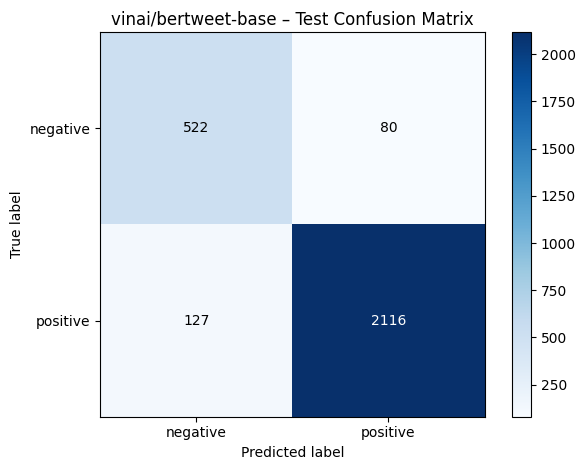


===== Final evaluation on TEST for roberta-base =====


Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]

Test loss  : 0.3158
Test Acc   : 0.9269
Test AvgRec: 0.8880
Test F1_mac: 0.8899

Classification report:


,precision,recall,f1-score,support
negative,0.831650,0.820598,0.826087,602.000000
positive,0.952021,0.955417,0.953716,2243.000000
accuracy,0.926889,0.926889,0.926889,0.926889
macro avg,0.891836,0.888007,0.889902,2845.000000
weighted avg,0.926551,0.926889,0.926710,2845.000000



Confusion matrix (counts):


,pred_neg,pred_pos
true_neg,494,108
true_pos,100,2143


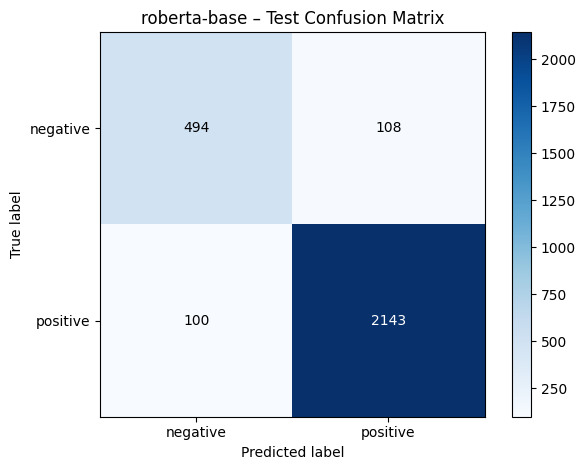


===== Summary of TEST metrics by model =====


,model_name,test_loss,test_accuracy,test_avgrec,test_f1_macro
0,vinai/bertweet-base,0.282839,0.927241,0.905245,0.893950
1,roberta-base,0.315838,0.926889,0.888007,0.889902


In [ ]:
# ============================================================
# 11. Final evaluation on TEST set (Subtask B)
# ============================================================
test_results = []

for mname in MODEL_NAMES:
    print(f"\n===== Final evaluation on TEST for {mname} =====")

    model     = models[mname]
    tokenizer = tokenizers[mname]

    # IMPORTANT: shuffle=False to preserve row order
    test_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE, label2id, shuffle=False)
    test_loss, y_true, y_pred = eval_model(model, test_loader, device)
    metrics = compute_metrics_binary(y_true, y_pred)

    print(f"Test loss  : {test_loss:.4f}")
    print(f"Test Acc   : {metrics['accuracy']:.4f}")
    print(f"Test AvgRec: {metrics['avgrec']:.4f}")
    print(f"Test F1_mac: {metrics['f1_macro']:.4f}")

    # Classification report
    report_df = pd.DataFrame(metrics["report"]).T
    print("\nClassification report:")
    display(report_df)

    # Confusion matrix (counts)
    cm = confusion_matrix(
        y_true,
        y_pred,
        labels=[label2id["negative"], label2id["positive"]],
    )
    cm_df = pd.DataFrame(
        cm,
        index=["true_neg", "true_pos"],
        columns=["pred_neg", "pred_pos"],
    )
    print("\nConfusion matrix (counts):")
    display(cm_df)

    plot_confusion_matrix(cm, ["negative", "positive"],
                          title=f"{mname} – Test Confusion Matrix")

    test_results.append({
        "model_name": mname,
        "test_loss": test_loss,
        "test_accuracy": metrics["accuracy"],
        "test_avgrec": metrics["avgrec"],
        "test_f1_macro": metrics["f1_macro"],
    })

test_results_df = pd.DataFrame(test_results)
print("\n===== Summary of TEST metrics by model =====")
display(test_results_df)

# 12. Save models, best checkpoints, and CSV metrics (Subtask B)

In [ ]:
# ============================================================
# 12. Save models, best checkpoints, and CSV metrics (Subtask B)
# ============================================================
base_dir = "saved_models_subtaskB"
os.makedirs(base_dir, exist_ok=True)

for mname in MODEL_NAMES:
    clean_name = mname.replace("/", "_")
    model_dir = os.path.join(base_dir, clean_name)
    os.makedirs(model_dir, exist_ok=True)
    print("Saving", mname, "to", model_dir)
    models[mname].save_pretrained(model_dir)
    tokenizers[mname].save_pretrained(model_dir)

# Convenient "best" dirs for inference / slides
bertweet_name = "vinai/bertweet-base"
roberta_name  = "roberta-base"

os.makedirs("bertweet_subtaskB_best", exist_ok=True)
os.makedirs("roberta_subtaskB_best", exist_ok=True)

print("Saving best BERTweet checkpoint to 'bertweet_subtaskB_best/'")
models[bertweet_name].save_pretrained("bertweet_subtaskB_best")
tokenizers[bertweet_name].save_pretrained("bertweet_subtaskB_best")

print("Saving best RoBERTa checkpoint to 'roberta_subtaskB_best/'")
models[roberta_name].save_pretrained("roberta_subtaskB_best")
tokenizers[roberta_name].save_pretrained("roberta_subtaskB_best")

# Save training history & test summary as CSVs
history_path = "history_subtaskB_all.csv"
testres_path = "test_results_subtaskB.csv"

history_all.to_csv(history_path, index=False)
test_results_df.to_csv(testres_path, index=False)

print("\nSaved CSVs:")
print("  Training history ->", os.path.abspath(history_path))
print("  Test results     ->", os.path.abspath(testres_path))


Saving vinai/bertweet-base to saved_models_subtaskB/vinai_bertweet-base
Saving roberta-base to saved_models_subtaskB/roberta-base
Saving best BERTweet checkpoint to 'bertweet_subtaskB_best/'
Saving best RoBERTa checkpoint to 'roberta_subtaskB_best/'

Saved CSVs:
  Training history -> /content/history_subtaskB_all.csv
  Test results     -> /content/test_results_subtaskB.csv
